# Hadoop Assignment

> Georgios Liargkovas | 8180061 | gliargovas@aueb.gr <br/>
> Georgios - Petros Drosos | 8180024 | t8180024@aueb.gr <br/>
> Big Data Management Systems Course 2022 <br/>
> Professor: Damianos Chatziantoniou <br/>

## Installation

* Firstly, we install hadoop on our local system. 
* By following the instructions found in [this](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html) tutorial. 
* The machine on which the hadoop MapReduce jobs were run had Ubuntu 20.04 installed and run the (Apache Hadoop 3.2.3 distribution).
* The separate user was created for the purposes of the assignment.

* We can verify correct installarion by running the `bin/hdfs version` command in hadoop's root directory.

The following output is generated:

In [124]:
%%html
<pre><font color="#4E9A06"><b>hadoop@gliargkvas-XPS-13-7390</b></font>:<font color="#3465A4"><b>~/hadoop-3.2.3</b></font>$ bin/hdfs version
Hadoop 3.2.3
Source code repository https://github.com/apache/hadoop -r abe5358143720085498613d399be3bbf01e0f131
Compiled by ubuntu on 2022-03-20T01:18Z
Compiled with protoc 2.5.0
From source with checksum 39bb14faec14b3aa25388a6d7c345fe8
This command was run using /home/hadoop/hadoop-3.2.3/share/hadoop/common/hadoop-common-3.2.3.jar
</pre>

## Point generation

For the generation of the points, we have created a python script named `generate_points.py`. With this script, we will generate 1.5 million distinct points.

Below we present the inner workings of **generate_points.py**

* We first import the required packages for the generator.

In [125]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

* We will use the `sklearn.datasets.make_blobs()` method to generate the points used for the requirements of the assignment.

* We also get the centers of the three areas.

In [126]:
X, y, centers = make_blobs(n_samples=1500000, 
                           centers=3, 
                           cluster_std=150, 
                           random_state=8, 
                           center_box=(-1000, 1000), 
                           return_centers=True)

* We then set the coordinates of each center to a 5 digit decimal point precision and save the points and the centers in separate files:

In [127]:
pts = []
for e in X:
    pts.append([e[0].round(5), e[1].round(5)])
    
ctrs = []
for e in centers:
    ctrs.append([e[0].round(5), e[1].round(5)])


In [128]:
with open('input/points.txt', 'w') as pf:
    for point in pts:
        pf.write(f"{point[0]} {point[1]}\n")
    
with open('input/centers.txt', 'w') as cf:
    for point in ctrs:
        cf.write(f"{point[0]} {point[1]}\n")

* The points generated can be seen below:

/home/gliargkvas/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


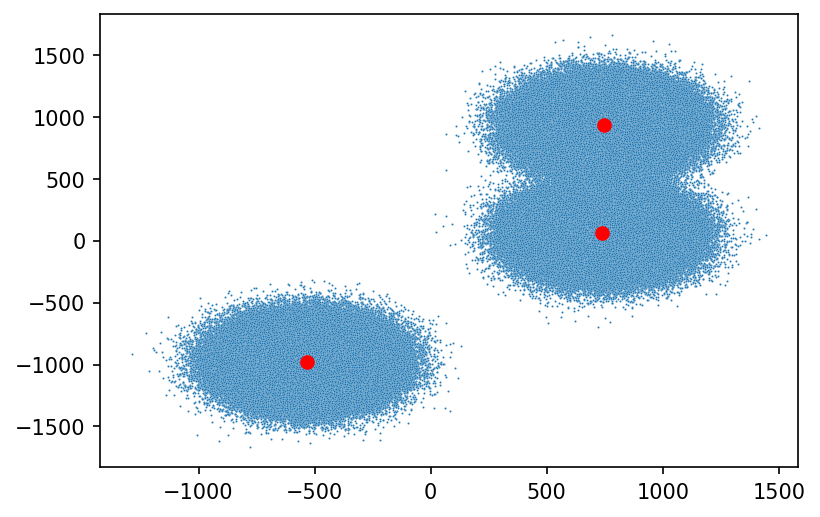

In [129]:
plt.rcParams['figure.dpi'] = 150

ax = sns.scatterplot(X[:,0], X[:,1], s=1, alpha=1)
plt.scatter(centers[:,0], centers[:,1], color='r')

## Moving the files to HDFS

* The point and center files have been moved to HDFS in the `/input` directory using the command `bin/hdfs dfs -put points.txt ./input`.

* To verify that the necessary files are successfully imported into the HDFS, we run the command `bin/hdfs dfs -ls ./input`. We get the output below:

In [130]:
%%html
<pre><font color="#4E9A06"><b>hadoop@gliargkvas-XPS-13-7390</b></font>:<font color="#3465A4"><b>~/hadoop-3.2.3</b></font>$ bin/hdfs dfs -ls input/
Found 2 items
-rw-r--r--   1 hadoop hadoop         61 2022-04-13 23:03 input/centers.txt
-rw-r--r--   1 hadoop hadoop   30757129 2022-04-12 13:47 input/points.txt
</pre>

## 4. MapReduce jobs

For the fourth task, we created 5 files in total: mapper.py, reducer.py, run.sh, centers.txt and points.txt. They are need to be saved in the same directory.
* The [centers.txt](centers.txt) file includes three centers (x,y), that the k-means algorithm gets as initial centers. These points were selected above in order to create the data file. 
* The [points.txt](points.txt) was generated in section 2.
* The [mapper.py](mapper.py) contains the map function.
* The [reducer.py](reducer.py) containes the reduce function.
* [run.sh](run.sh) is a script that automates the execution of the MapReduce job on Linux based systems and Windows powershell.

### mapper.py

The mapper takes as an input the points file (through the stdin) and the centers file. It then maps every point to the closest center and finally returns (through the stdout) a set of coordinates which represent the point along with the closest center number. (*e.g.* The line `652.13167,911.93309	1` means that the point with (x,y) coordinates (652.13167,911.93309), is closer to the center of cluster 1 of the centers.txt file).

Below we present the code for the mapper.py map script:

* At first we import the necessary functions

In [131]:
import sys
import math

* Below we declare some functions to read the necessary input

In [132]:
def read_input(file):
    for line in file:
        yield line.replace("\n", "").split(" ")


def read_centers():
    with open("input/centers.txt", "r") as f:
        center1 = f.readline().strip().split(" ")
        center1 = tuple([float(i) for i in center1])
        center2 = f.readline().strip().split(" ")
        center2 = tuple([float(i) for i in center2])
        center3 = f.readline().strip().split(" ")
        center3 = tuple([float(i) for i in center3])
    return center1, center2, center3

* Below we define a metod that calculates the euclidean distance between two points

In [133]:
def euclidean(p1, p2):
    return math.sqrt(abs(p1[0] - p2[0])**2 + abs(p1[1] - p2[1])**2)

* Finally, we define the main function, that performs the mapping of the points to the closest centers.
* The output generated consists of the point and the closest center number (either center1, center2 or center3).

In [134]:
def main(separator='\t'):
    center_dict = {}
    c1, c2, c3 = read_centers()
    center_dict = {c1:1, c2:2, c3:3}
    data = read_input(sys.stdin)
    for words in data:
        point = tuple([float(i) for i in words])
        center_mapper = {}
        center_mapper[c1] = euclidean(point, c1)
        center_mapper[c2] = euclidean(point, c2)
        center_mapper[c3] = euclidean(point, c3)
        center = min(center_mapper, key=center_mapper.get)
        output_point = ','.join(str(v) for v in list(point))
        print(f"{output_point}{separator}{center_dict.get(center)}")
        
if __name__ == "__main__":
    main()

To demonstrate the mapper's operation, we run the following command that performs the mapping for the first 10 entries of the points file:

In [135]:
! head input/points.txt | python3 mapper.py

652.13167,911.93309	1
806.96304,986.04514	1
651.04872,882.08472	1
777.4219,36.52721	2
722.60787,826.99597	1
700.30361,73.01675	2
795.99177,-224.8845	2
-318.07526,-925.23851	3
552.00247,911.85478	1
720.90674,1217.38617	1


### reducer.py

The reducer script takes as an input the output of the mapper file (i.e. a set of coordinates along with the closest center number, separated by the `\t` character). It then calculates the new centroid of each set of points provided by the input and finally returns the number of each cluster along with the coordinates of the new center.

Below we present the code for the mapper.py map script:

* At first we import sys to read from the stdin

In [136]:
import sys

* Below we define a dictionary containing the different points that are closer to a specific center. For example, `point_dict[1]` contains all the points closest to center 1 (1st line of the [points.txt](points.txt) file).

* We also create a dictionary to store the new centers after they are calculated.

In [137]:
point_dict = {
        1:[],
        2:[],
        3:[]
    }

new_centers = {}

* Below we read the output provided by the mapper.py, captured from the stdin.

In [138]:
def read_mapper_output(file, separator='\t'):
    for line in file:
        yield line.rstrip().split(separator, 1)

* Finally, in the main funcion we populate the point_dict and we then calculate the centroid for each dictionary entry. We then proceed to print the output.

In [142]:

def main(separator='\t'):
    # input comes from STDIN (standard input)
    data = read_mapper_output(sys.stdin, separator=separator)

    for point, group in data:
        x, y = point.split(",")
        point_dict[int(group)].append((float(x),float(y)))

    for i in point_dict:
        x = [p[0] for p in point_dict[i]]
        y = [p[1] for p in point_dict[i]]
        centroid = (sum(x) / len(point_dict[i]), sum(y) / len(point_dict[i]))
        new_centers[i]= centroid

    for i in point_dict:
            print(f"{i}{separator}{new_centers[i]}")

if __name__ == "__main__":
    main()

To demonstrate the reducers's operation, we run the following command that performs the mapping for the first 10 entries of the points file and then applies the reduce sctipt in order to calculate the new centroids:

In [143]:
! head input/points.txt | python3 mapper.py | python3 reducer.py

1	(684.2767516666667, 956.0499783333333)
2	(757.9057600000001, -38.446846666666666)
3	(-318.07526, -925.23851)


### Results visualization

Below we visualize the results by showing mapper splitting the points into 3 clusters according to their distance from the initial centers and then calculating the new centers.

In the cell below we declare some helper functiona to plot the point clusters from the mapper along with the new centers.

In [115]:
def read_mapper_output(file, separator='\t'):
    with open(file, "r") as file:
        for line in file:
            yield line.rstrip().split(separator)
            
def read_reducer_output(file, separator='\t'):
    with open(file, "r") as file:
        for line in file:
            yield line.rstrip().split(separator)
X = []
Y = []
C = []
for line in read_mapper_output("mapping.txt"):
    x, y = [float(x) for x in line[0].split(",")]
    X.append(x)
    Y.append(y)
    C.append(line[1])

CX = []
CY = []
for line in read_mapper_output("reducer.txt"):
    x, y = [float(x) for x in line[1].replace("(", "").replace(")", "").split(",")]
    CX.append(x)
    CY.append(y)

[747.0161395174879, 738.3454184984232, -534.7276890083881] [937.4753348230499, 61.46067184938273, -977.5665006197586]


/home/gliargkvas/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


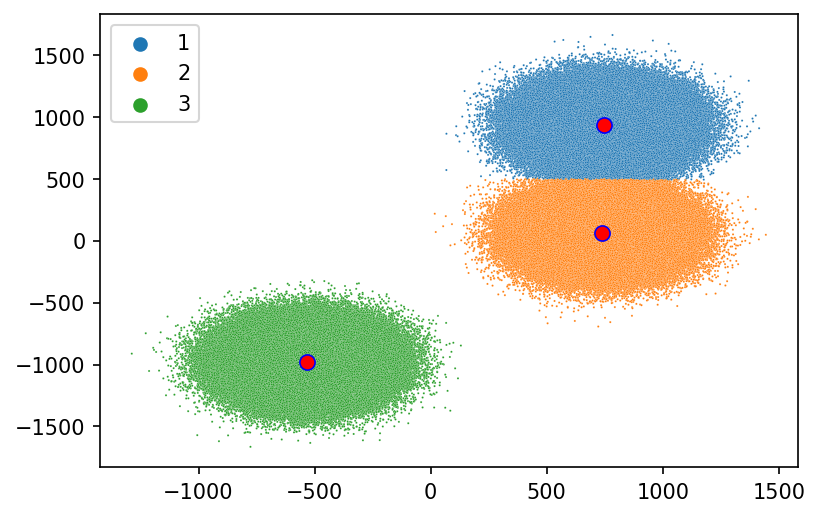

In [116]:
ax1 = sns.scatterplot(X, Y, s=1, alpha=1, hue=C)
plt.scatter(centers[:,0], centers[:,1], color='b', s=50)
plt.scatter(CX, CY, color='r', s=30)

We can see that the new centers are almost identical. This is because the generated points are normally distributed from the centers and due to the large number of points, the centroids are expected to remain in a very similar position.

By repeating the process above but with only 10 points, we see that the cluster centers actually changed

/home/gliargkvas/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


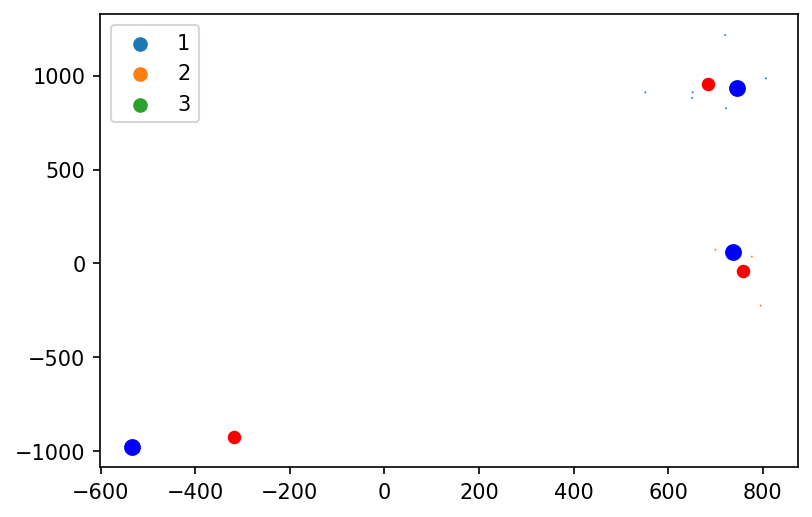

In [114]:
ax2 = sns.scatterplot(X, Y, s=1, alpha=1, hue=C)
plt.scatter(centers[:,0], centers[:,1], color='b', s=50)
plt.scatter(CX, CY, color='r', s=30)

### run.sh

The command used to execute hadoop mapreduce is presented below:

    bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-3.2.3.jar -file mapper.py -file reducer.py -mapper "python mapper.py" -reducer "python reducer.py" -input input/points.txt -output output

The above command, while run in hadoop's main directory, produces the following output:

**NOTE:** If command output does not display, try openning the [./hadoop_output.html](hadoop_output.html) file

In [147]:
%%html

IFrame(src='./hadoop_output.html', width=900, height=600)

The results are saved to the `output` directory where the contents of the output file contain the cluster centers:

In [144]:
!ls /home/hadoop/hadoop-3.2.3/output/

part-00000  _SUCCESS


The existence of the `_SUCCESS` file indicates that the MapReduce job was successful

By taking a look in the `part-00000` file, we can see that the new cluster centers were calculated successfully.

In [145]:
!cat /home/hadoop/hadoop-3.2.3/output/part-00000

1	(747.0161395174823, 937.4753348230657)
2	(738.3454184984423, 61.46067184938388)
3	(-534.727689008402, -977.5665006197672)
